# Imports

In [60]:
import numpy as np
import pandas as pd


In [61]:
import re
from string import punctuation
import emoji

In [62]:
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, SimpleRNN, GRU

In [63]:
import matplotlib.pyplot as plt

In [64]:
nltk.download("punkt_tab")
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Vars definition

In [65]:
n_gram = 4
window_size = 5
percent_sample = 0.01

In [66]:
stop_words = set(stopwords.words("english"))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

# Data preparation

## Initial clean

In [67]:
df = pd.read_csv("data/data.csv")
df

,product_name,overall_rating,no_ratings,no_reviews,rating,title,review
0,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Perfect product!,"Loved it, it's my first MacBook that I earned ..."
1,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Fabulous!,Battery lasted longer than my first relationsh...
2,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Fabulous!,Such a great deal.. very happy with the perfor...
3,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,4,Delightful,"Awesome build quality and very good display, b..."
4,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Awesome,When i ordered and came to know about seller r...
...,...,...,...,...,...,...,...
24108,MSI Modern 14 Intel Core i5 13th Gen 1335U - (...,4.3,156,24,5,Perfect product!,MSI Laptop is high performance and the best. c...
24109,MSI Modern 14 Intel Core i5 13th Gen 1335U - (...,4.3,156,24,5,Perfect product!,Excellent performance best laptop.
24110,MSI Modern 14 Intel Core i5 13th Gen 1335U - (...,4.3,156,24,4,"Good product, Lacks features.",Decent battery life. Exceptional build quality...
24111,Lenovo IdeaPad 5 2-in-1 WUXGA IPS AMD Ryzen 7 ...,4.4,7,2,3,Nice,The product does not support facial recognitio...


In [68]:
df_review = df[["review"]]
df_review

,review
0,"Loved it, it's my first MacBook that I earned ..."
1,Battery lasted longer than my first relationsh...
2,Such a great deal.. very happy with the perfor...
3,"Awesome build quality and very good display, b..."
4,When i ordered and came to know about seller r...
...,...
24108,MSI Laptop is high performance and the best. c...
24109,Excellent performance best laptop.
24110,Decent battery life. Exceptional build quality...
24111,The product does not support facial recognitio...


In [69]:
def clean_text_dataframe(
    df_i: pd.DataFrame,
    columns: list[str] | None = None,
    keep_apostrophe: bool = True,
    min_words: int = n_gram,
) -> pd.DataFrame:
    """
    Очищает текст и удаляет строки с малым количеством слов

    Params:
        df (pd.DataFrame): Исходный DataFrame
        columns (list[str]|None): Столбцы для обработки (None = все строковые)
        keep_apostrophe (bool): Сохранять апострофы (по умолчанию True)
        min_words (int): Минимальное количество слов для сохранения строки

    Return:
        pd.DataFrame: Очищенная и отфильтрованная копия DataFrame
    """
    df_clean = df_i.copy()

    # Определение целевых столбцов
    if columns is None:
        columns = df_clean.select_dtypes(include=["object", "string"]).columns.tolist()

    # Настройка паттерна для пунктуации
    punct_pattern = r"[{}]".format(
        re.escape(
            punctuation.replace("'", "") if keep_apostrophe else re.escape(punctuation)
        )
    )

    def text_cleaner(text):
        if not isinstance(text, str):
            return text

        # Удаление эмодзи
        text = emoji.replace_emoji(text, replace="")

        # Удаление пунктуации
        text = re.sub(punct_pattern, " ", text)

        # Удаление спецсимволов
        text = re.sub(r"[^a-zA-Z0-9\'\s]", " ", text)

        # Нормализация пробелов
        text = re.sub(r"\s+", " ", text).strip()

        return text

    for col in columns:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].apply(text_cleaner)

    word_count_mask = (
        df_clean[columns]
        .apply(lambda col: col.str.split().str.len() > min_words)
        .all(axis=1)
    )

    df_clean = df_clean[word_count_mask].reset_index(drop=True)

    return df_clean

In [70]:
df_review = clean_text_dataframe(df_review, min_words=n_gram)
df_review

,review
0,Loved it it's my first MacBook that I earned f...
1,Battery lasted longer than my first relationsh...
2,Such a great deal very happy with the performa...
3,Awesome build quality and very good display ba...
4,When i ordered and came to know about seller r...
...,...
15887,Plastic body Body was a very bad
15888,MSI Laptop is high performance and the best co...
15889,Decent battery life Exceptional build quality ...
15890,The product does not support facial recognitio...


## Data tokenize

### Create

In [71]:
def tokenize_text_dataframe(df_i: pd.DataFrame, tokenizer):
    return pd.DataFrame(
        df_i.iloc[:, 0].apply(
            lambda col: [
                word for word in tokenizer(col.lower()) if word not in stop_words
            ]
        )
    )

In [72]:
df_tokens = tokenize_text_dataframe(
    df_review, TweetTokenizer(match_phone_numbers=False).tokenize
)
df_tokens

,review
0,"[loved, first, macbook, earned, hardwork]"
1,"[battery, lasted, longer, first, relationship,..."
2,"[great, deal, happy, performance, battery, lif..."
3,"[awesome, build, quality, good, display, batte..."
4,"[ordered, came, know, seller, review, scared, ..."
...,...
15887,"[plastic, body, body, bad]"
15888,"[msi, laptop, high, performance, best, configu..."
15889,"[decent, battery, life, exceptional, build, qu..."
15890,"[product, support, facial, recognition, ir, se..."


In [73]:
df_tokens = df_tokens[df_tokens["review"].apply(lambda col: len(col) > n_gram)].reset_index(drop=True).sample(frac=percent_sample)
df_tokens

,review
8810,"[laptop, manufacturing, date, old, made, 3, mo..."
7916,"[display, bleeding, issue, put, dark, screen, ..."
5655,"[everything, good, bt, little, bit, heating, p..."
1328,"[best, laptop, 35k, impressed, looks, designed..."
12041,"[yes, good, performance, like, aeroplane]"
...,...
4385,"[display, 4, 5, performance, 5, 5, battery, 4,..."
10388,"[use, laptop, form, 2, months, totally, disapp..."
4756,"[heating, much, high, cpu, temperature, even, ..."
9563,"[best, laptop, price, wonderful, laptop]"


In [137]:
df_tokens.to_csv(f'data/df_tokens_{percent_sample}.csv')

### Load

In [ ]:
df_tokens = pd.read_csv(f'data/df_tokens_{percent_sample}.csv')

## Tokens process

In [74]:
def vocab_text_dataframe(df_i: pd.DataFrame):
    return pd.DataFrame(df_i.iloc[:, 0].apply(lambda col: sorted(set(col))))


def idx_text_dataframe(df_i: pd.DataFrame):
    return pd.DataFrame(
        df_i.iloc[:, 0].apply(lambda col: {word: idx for idx, word in enumerate(col)})
    )


def global_idx_text_dataframe(df_i: pd.DataFrame):
    """
    Создаёт словарь {слово: индекс} для всех уникальных слов
    из объединённой первой колонки DataFrame, сохраняя порядок появления слов.
    Возвращает DataFrame с одним словарём в виде строки.
    """
    # Объединяем все элементы из первой колонки в один список
    all_words = sum(df_i.iloc[:, 0].tolist(), [])

    # Удаляем дубликаты с сохранением порядка первого появления
    unique_words = list(set(all_words))

    # Создаём итоговый словарь {слово: индекс}
    combined_dict = {word: idx for idx, word in enumerate(unique_words)}

    return pd.DataFrame(list(combined_dict.items()), columns=["Word", "Index"])

In [75]:
df_vocab = vocab_text_dataframe(df_tokens)
df_word_to_idx = idx_text_dataframe(df_vocab)
df_global_word_to_idx = global_idx_text_dataframe(df_vocab)

In [76]:
df_word_to_idx

,review
8810,"{'3': 0, 'applications': 1, 'better': 2, 'boug..."
7916,"{'100srgb': 0, '16gb': 1, '2': 2, '4': 3, '4x'..."
5655,"{'4': 0, '5': 1, 'battery': 2, 'bit': 3, 'bt':..."
1328,"{'35k': 0, 'also': 1, 'best': 2, 'buy': 3, 'de..."
12041,"{'aeroplane': 0, 'good': 1, 'like': 2, 'perfor..."
...,...
4385,"{'35k': 0, '4': 1, '5': 2, 'app': 3, 'awesome'..."
10388,"{'2': 0, 'button': 1, 'centre': 2, 'charging':..."
4756,"{'condition': 0, 'cpu': 1, 'even': 2, 'heating..."
9563,"{'best': 0, 'laptop': 1, 'price': 2, 'wonderfu..."


In [77]:
df_vocab

,review
8810,"[3, applications, better, bought, cleared, con..."
7916,"[100srgb, 16gb, 2, 4, 4x, 5, anti, battery, be..."
5655,"[4, 5, battery, bit, bt, decent, display, ever..."
1328,"[35k, also, best, buy, designed, doubt, go, go..."
12041,"[aeroplane, good, like, performance, yes]"
...,...
4385,"[35k, 4, 5, app, awesome, backlit, battery, bo..."
10388,"[2, button, centre, charging, disappointed, ev..."
4756,"[condition, cpu, even, heating, high, ideal, m..."
9563,"[best, laptop, price, wonderful]"


In [78]:
df_word_to_idx

,review
8810,"{'3': 0, 'applications': 1, 'better': 2, 'boug..."
7916,"{'100srgb': 0, '16gb': 1, '2': 2, '4': 3, '4x'..."
5655,"{'4': 0, '5': 1, 'battery': 2, 'bit': 3, 'bt':..."
1328,"{'35k': 0, 'also': 1, 'best': 2, 'buy': 3, 'de..."
12041,"{'aeroplane': 0, 'good': 1, 'like': 2, 'perfor..."
...,...
4385,"{'35k': 0, '4': 1, '5': 2, 'app': 3, 'awesome'..."
10388,"{'2': 0, 'button': 1, 'centre': 2, 'charging':..."
4756,"{'condition': 0, 'cpu': 1, 'even': 2, 'heating..."
9563,"{'best': 0, 'laptop': 1, 'price': 2, 'wonderfu..."


In [79]:
df_global_word_to_idx

,Word,Index
0,planning,0
1,surely,1
2,mth,2
3,flat,3
4,premium,4
...,...,...
884,4th,884
885,useless,885
886,almost,886
887,secondly,887


In [80]:
tokens = df_tokens.iloc[:, 0].to_list()
vocab = df_vocab.iloc[:, 0].to_list()
global_vocab = list(sorted(set([item for sublist in vocab for item in sublist])))
vocab_size = len(global_vocab)
word_to_idx = df_word_to_idx.iloc[:, 0].to_list()
global_word_to_idx = {
    v: k for k, v in df_global_word_to_idx.iloc[:, 0].to_dict().items()
}
global_idx_to_word = {v: k for k, v in global_word_to_idx.items()} 

In [81]:

word_to_idx

[{'3': 0,
  'applications': 1,
  'better': 2,
  'bought': 3,
  'cleared': 4,
  'configuration': 5,
  'date': 6,
  'decent': 7,
  'discount': 8,
  'earlier': 9,
  'even': 10,
  'gaming': 11,
  'good': 12,
  'heavy': 13,
  'however': 14,
  'laptop': 15,
  'made': 16,
  'manufactured': 17,
  'manufacturing': 18,
  'many': 19,
  'meant': 20,
  'months': 21,
  'old': 22,
  'overall': 23,
  'period': 24,
  'price': 25,
  'product': 26,
  'products': 27,
  'professionals': 28,
  'purchase': 29,
  'since': 30,
  'students': 31,
  'times': 32},
 {'100srgb': 0,
  '16gb': 1,
  '2': 2,
  '4': 3,
  '4x': 4,
  '5': 5,
  'anti': 6,
  'battery': 7,
  'becomes': 8,
  'bleeding': 9,
  'breaker': 10,
  'budget': 11,
  'build': 12,
  'colour': 13,
  'daily': 14,
  'dark': 15,
  'deal': 16,
  'density': 17,
  'display': 18,
  'due': 19,
  'even': 20,
  'exept': 21,
  'fine': 22,
  'full': 23,
  'gamut': 24,
  'good': 25,
  'grare': 26,
  'great': 27,
  'hd': 28,
  'high': 29,
  'intensive': 30,
  'issue': 

In [82]:
global_word_to_idx

{'planning': 0,
 'surely': 1,
 'mth': 2,
 'flat': 3,
 'premium': 4,
 'plastic': 5,
 'config': 6,
 '100': 7,
 'even': 8,
 'times': 9,
 'width': 10,
 'worth': 11,
 'slot': 12,
 'satisfied': 13,
 'build': 14,
 '720hd': 15,
 '80w': 16,
 'turning': 17,
 'possibilty': 18,
 'soft': 19,
 'superb': 20,
 '2nd': 21,
 'ideal': 22,
 'plugged': 23,
 'setting': 24,
 'ur': 25,
 'opinion': 26,
 'lpddr': 27,
 'sturdy': 28,
 'less': 29,
 'point': 30,
 'aeroplane': 31,
 '68k': 32,
 'excellent': 33,
 'second': 34,
 'lookwise': 35,
 'apart': 36,
 'installed': 37,
 'android': 38,
 'able': 39,
 'low': 40,
 'viewing': 41,
 'whenever': 42,
 'extra': 43,
 'integrated': 44,
 'loving': 45,
 'fantastic': 46,
 'laptp': 47,
 'kids': 48,
 'videos': 49,
 'nothin': 50,
 'buying': 51,
 'worker': 52,
 'include': 53,
 'lenovo': 54,
 'studio': 55,
 'room': 56,
 'fx': 57,
 '70': 58,
 'year': 59,
 'class': 60,
 'small': 61,
 'catch': 62,
 'notebook': 63,
 'pleasure': 64,
 'hesitation': 65,
 'utterly': 66,
 'talking': 67,
 'la

In [83]:
len(global_vocab)

889

In [84]:
vocab

[['3',
  'applications',
  'better',
  'bought',
  'cleared',
  'configuration',
  'date',
  'decent',
  'discount',
  'earlier',
  'even',
  'gaming',
  'good',
  'heavy',
  'however',
  'laptop',
  'made',
  'manufactured',
  'manufacturing',
  'many',
  'meant',
  'months',
  'old',
  'overall',
  'period',
  'price',
  'product',
  'products',
  'professionals',
  'purchase',
  'since',
  'students',
  'times'],
 ['100srgb',
  '16gb',
  '2',
  '4',
  '4x',
  '5',
  'anti',
  'battery',
  'becomes',
  'bleeding',
  'breaker',
  'budget',
  'build',
  'colour',
  'daily',
  'dark',
  'deal',
  'density',
  'display',
  'due',
  'even',
  'exept',
  'fine',
  'full',
  'gamut',
  'good',
  'grare',
  'great',
  'hd',
  'high',
  'intensive',
  'issue',
  'laptop',
  'low',
  'lpddr',
  'meant',
  'moreover',
  'new',
  'offering',
  'overally',
  'perfectly',
  'pixel',
  'put',
  'quality',
  'ram',
  'read',
  'screen',
  'speed',
  'ssd',
  'still',
  'tasks',
  'though',
  'versio

In [85]:
global_vocab

["'",
 '0',
 '09',
 '1',
 '10',
 '100',
 '100srgb',
 '11',
 '115w',
 '11gen',
 '12',
 '12650h',
 '128',
 '12yrs',
 '14',
 '15',
 '16',
 '16gb',
 '17k',
 '1week',
 '2',
 '20',
 '2016',
 '2021',
 '2023',
 '24watt',
 '256gb',
 '27',
 '2hour',
 '2k',
 '2lakh',
 '2nd',
 '3',
 '30',
 '35k',
 '38k',
 '3d',
 '3hrs',
 '3months',
 '4',
 '4060',
 '40k',
 '45',
 '45000',
 '475',
 '4h',
 '4k',
 '4th',
 '4x',
 '5',
 '50k',
 '512gb',
 '55k',
 '5h',
 '5hrs',
 '6',
 '65w',
 '68k',
 '7',
 '70',
 '70k',
 '720hd',
 '8',
 '80w',
 '8gb',
 '8h',
 '8hrs',
 '9hrs',
 'able',
 'acer',
 'activate',
 'actually',
 'adaptor',
 'add',
 'adding',
 'adjustable',
 'aeroplane',
 'ago',
 'allowed',
 'almost',
 'already',
 'also',
 'although',
 'amazing',
 'android',
 'angle',
 'angles',
 'annoying',
 'another',
 'answer',
 'anti',
 'apart',
 'app',
 'apple',
 'application',
 'applications',
 'approx',
 'approximately',
 'aprrox',
 'architect',
 'around',
 'asphalt',
 'assassins',
 'automatically',
 'available',
 'average'

## Token preparation

### BoW

In [86]:
corpus, y_bow = [], []
for idx, cur_token in enumerate(tokens
                                # [: 2 * len(tokens) // 3]
                                ):
    for i in range(len(cur_token) - window_size):
        context = cur_token[i : i + window_size]
        corpus.append(" ".join(context))
        y_bow.append(global_word_to_idx[cur_token[i + window_size]])
        # y_bow.append(word_to_idx[idx][cur_token[i + window_size]])

vectorizer = CountVectorizer(vocabulary=global_vocab)
X_bow = vectorizer.fit_transform(corpus).toarray()
y_bow = np.array(y_bow)

#### df

In [87]:
# df_bow = pd.DataFrame({"x": X_bow.tolist(), "y": y_bow.tolist()})
# df_bow

### N-gram

In [88]:
mass_sequences = []
for idx, cur_token in enumerate(tokens):
    mass_sequences.append([])
    for i in range(len(cur_token) - n_gram + 1):
        mass_sequences[idx].append(cur_token[i : i + n_gram])

X_ngram, y_ngram = [], []
for idx, sequences in enumerate(mass_sequences):
    for seq in sequences:
        # print(seq, word_to_idx)
        X_ngram.append([global_word_to_idx[word] for word in seq[:-1]])
        y_ngram.append(global_word_to_idx[seq[-1]])
        # X_ngram.append([word_to_idx[idx][word] for word in seq[:-1]])
        # y_ngram.append(word_to_idx[idx][seq[-1]])

X_ngram = np.array(X_ngram)
y_ngram = np.array(y_ngram)

#### df

In [89]:
# df_ngram = pd.DataFrame({"x": X_ngram.tolist(), "y": y_ngram.tolist()})
# df_ngram

## Data split

In [90]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    X_bow, y_bow, test_size=0.2
)

In [91]:
X_train_ng, X_test_ng, y_train_ng, y_test_ng = train_test_split(
    X_ngram, y_ngram, test_size=0.2
)

In [92]:
X_train_ng[0], y_train_ng[0]

(array([796, 184, 283]), np.int64(381))

In [93]:
X_train_ng.shape, y_train_ng.shape

((1633, 3), (1633,))

In [94]:
X_test_ng[0], y_test_ng[0]


(array([883, 883, 605]), np.int64(169))

In [95]:
X_test_ng.shape, y_test_ng.shape

((409, 3), (409,))

In [96]:
X_train_bow[0], y_train_bow[0]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [97]:
X_train_bow.shape, y_train_bow.shape

((1425, 889), (1425,))

In [98]:
X_test_bow[0], y_test_bow[0]


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [99]:
X_test_bow.shape, y_test_bow.shape

((357, 889), (357,))

# Models

## Graph

In [100]:
def plot_results(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Test Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Test Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

## Model preparing

### Dense

In [101]:
def dense_model(m_type, shape):
    model = Sequential(
        [
            Input((shape,)),
            Dense(128, activation="relu"),
            Dropout(0.05),
            Dense(vocab_size, activation="softmax"),
        ]
    )
    if m_type == "cat":
        c_loss = "categorical_crossentropy"
    elif m_type == "sp":
        c_loss = "sparse_categorical_crossentropy"
    else:
        print("WRONG TYPE!")
        return
    model.compile(loss=c_loss, optimizer="adam", metrics=["accuracy"])
    return model

### RNN

In [102]:
def rnn_model(m_type, shape):
    model = Sequential(
        [
            Embedding(vocab_size, 128, input_length=shape, mask_zero=True),
            SimpleRNN(128),
            Dropout(0.05),
            Dense(vocab_size, activation="softmax"),
        ]
    )
    if m_type == "cat":
        c_loss = "categorical_crossentropy"
    elif m_type == "sp":
        c_loss = "sparse_categorical_crossentropy"
    else:
        print("WRONG TYPE!")
        return
    model.compile(loss=c_loss, optimizer="adam", metrics=["accuracy"])
    return model

### GRU

In [103]:
def gru_model(m_type, shape):
    model = Sequential(
        [
            Embedding(vocab_size, 128, input_length=shape, mask_zero=True),
            GRU(128),
            Dropout(0.05),
            Dense(vocab_size, activation="softmax"),
        ]
    )
    if m_type == "cat":
        c_loss = "categorical_crossentropy"
    elif m_type == "sp":
        c_loss = "sparse_categorical_crossentropy"
    else:
        print("WRONG TYPE!")
        return
    model.compile(loss=c_loss, optimizer="adam", metrics=["accuracy"])
    return model

LSTM

In [104]:
def lstm_model(m_type, shape):
    model = Sequential(
        [
            Embedding(vocab_size, 128, input_length=shape, mask_zero=True),
            GRU(128),
            Dropout(0.05),
            Dense(vocab_size, activation="softmax"),
        ]
    )
    if m_type == "cat":
        c_loss = "categorical_crossentropy"
    elif m_type == "sp":
        c_loss = "sparse_categorical_crossentropy"
    else:
        print("WRONG TYPE!")
        return
    model.compile(loss=c_loss, optimizer="adam", metrics=["accuracy"])
    return model

## Model training

### Dense

#### Ngram

In [105]:
dense_ng = dense_model("sp", n_gram - 1)
dense_ng_hist = dense_ng.fit(X_train_ng, y_train_ng, epochs=10, validation_data=(X_test_ng, y_test_ng))

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.0036 - loss: 96.6650 - val_accuracy: 0.0073 - val_loss: 38.1366
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0017 - loss: 31.1417 - val_accuracy: 0.0073 - val_loss: 32.1286
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0124 - loss: 21.4102 - val_accuracy: 0.0073 - val_loss: 31.0783
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0065 - loss: 16.9255 - val_accuracy: 0.0073 - val_loss: 28.6757
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0077 - loss: 13.4344 - val_accuracy: 0.0098 - val_loss: 26.5423
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0092 - loss: 11.2343 - val_accuracy: 0.0073 - val_loss: 24.8580
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0160 - loss: 9.8441 - val_accuracy: 0.0196 - val_loss: 23.3043
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0120 - loss: 8.2363 - val_accuracy: 0.0

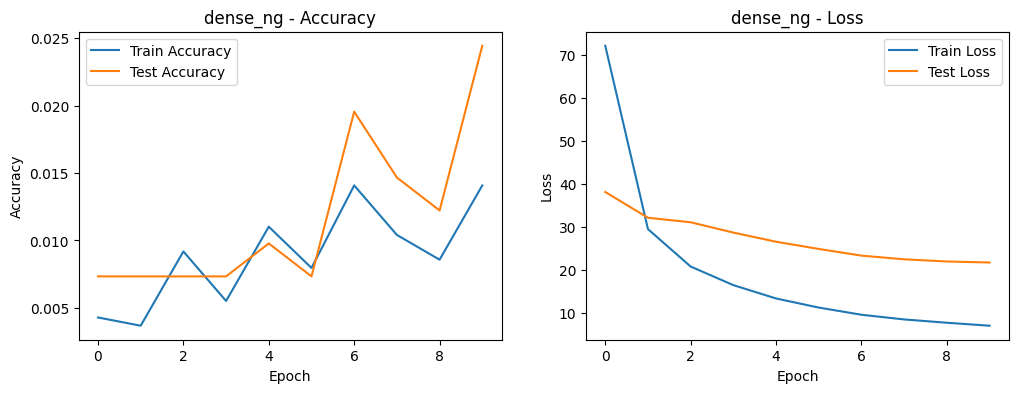

In [106]:
plot_results(dense_ng_hist, "dense_ng")

In [107]:
dense_ng.save(f"models/dense/ng_{percent_sample}.keras")

#### BoW

In [108]:
dense_bow = dense_model("sp", vocab_size)
dense_bow_hist = dense_bow.fit(
    X_train_bow, y_train_bow, epochs=20, validation_data=(X_test_bow, y_test_bow)
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0045 - loss: 6.7774 - val_accuracy: 0.0196 - val_loss: 6.7269
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0388 - loss: 6.5052 - val_accuracy: 0.0168 - val_loss: 6.5661
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0339 - loss: 5.8653 - val_accuracy: 0.0308 - val_loss: 6.7056
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0466 - loss: 5.4250 - val_accuracy: 0.0364 - val_loss: 6.8435
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0522 - loss: 5.1676 - val_accuracy: 0.0336 - val_loss: 6.9804
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0511 - loss: 4.9331 - val_accuracy: 0.0308 - val_loss: 7.1343
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0489 - loss: 4.6358 - val_accuracy: 0.0336 - val_loss: 7.2732
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0845 - loss: 4.2724 - val_accuracy: 0.0336 - v

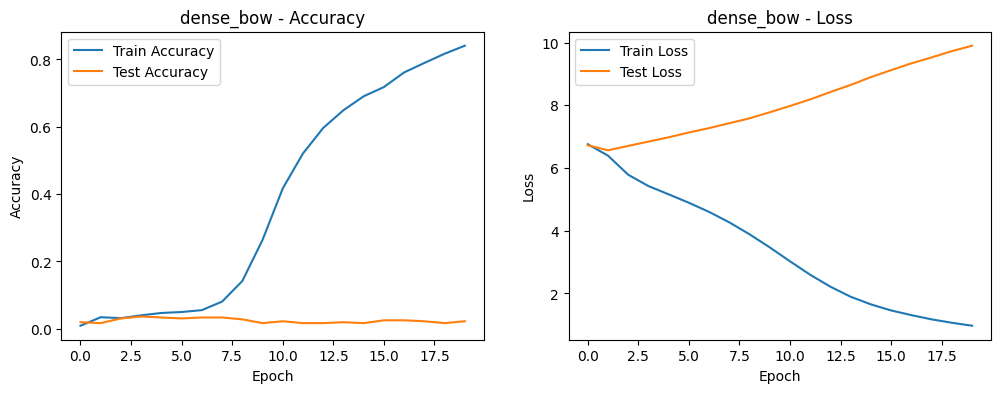

In [109]:
plot_results(dense_bow_hist, "dense_bow")

In [110]:
dense_bow.save(f"models/dense/bow_{percent_sample}.keras")

### RNN

#### Ngram

In [111]:
rnn_ng = rnn_model("sp", n_gram - 1)
rnn_ng_hist = rnn_ng.fit(X_train_ng, y_train_ng, epochs=10, validation_data=(X_test_ng, y_test_ng))


Epoch 1/10


c:\PyVenvs\Big_data_venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.0113 - loss: 6.7692 - val_accuracy: 0.0244 - val_loss: 6.5919
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0324 - loss: 6.0899 - val_accuracy: 0.0244 - val_loss: 6.6495
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0391 - loss: 5.7947 - val_accuracy: 0.0440 - val_loss: 6.9302
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0880 - loss: 5.6188 - val_accuracy: 0.0391 - val_loss: 6.9351
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1316 - loss: 5.2562 - val_accuracy: 0.0538 - val_loss: 6.9453
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2061 - loss: 4.7381 - val_accuracy: 0.0465 - val_loss: 6.9953
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3358 - loss: 4.1069 - val_accuracy: 0.0391 - val_loss: 7.1129
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4388 - loss: 3.4661 - val_accuracy: 0.0489 - val_loss: 7.

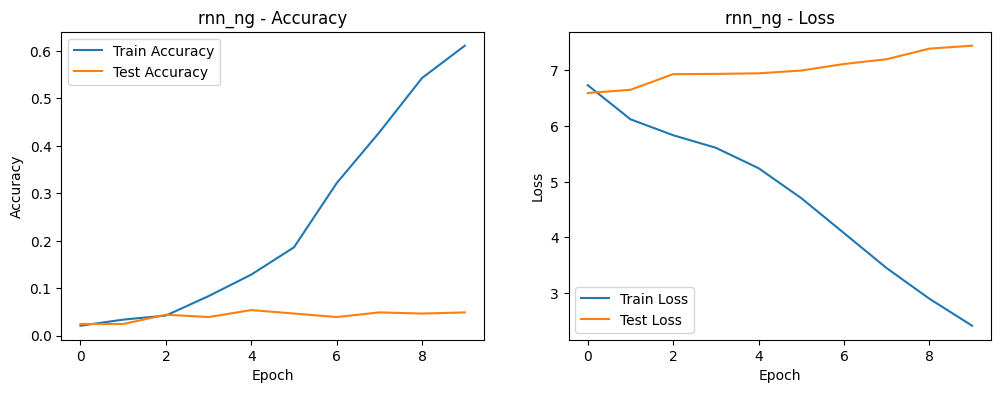

In [112]:
plot_results(rnn_ng_hist, "rnn_ng")


In [113]:
rnn_ng.save(f"models/rnn/ng_{percent_sample}.keras")

#### BoW

In [114]:
rnn_bow = rnn_model("sp", vocab_size)
rnn_bow_hist = rnn_bow.fit(X_train_bow, y_train_bow, epochs=5, validation_data=(X_test_bow, y_test_bow))

Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 480ms/step - accuracy: 0.0165 - loss: 6.7136 - val_accuracy: 0.0168 - val_loss: 6.6359
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 469ms/step - accuracy: 0.0254 - loss: 6.2385 - val_accuracy: 0.0196 - val_loss: 6.9137
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 446ms/step - accuracy: 0.0310 - loss: 6.0805 - val_accuracy: 0.0420 - val_loss: 7.0077
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - accuracy: 0.0328 - loss: 6.0594 - val_accuracy: 0.0280 - val_loss: 7.2163
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - accuracy: 0.0336 - loss: 6.0119 - val_accuracy: 0.0280 - val_loss: 7.2698


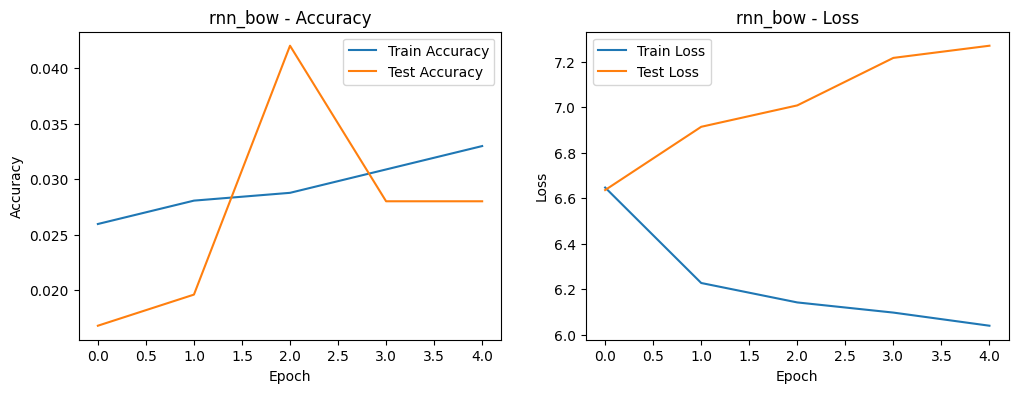

In [115]:
plot_results(rnn_bow_hist, "rnn_bow")

In [116]:
rnn_bow.save(f"models/rnn/bow_{percent_sample}.keras")

### GRU

#### Ngram

In [117]:
gru_ng = gru_model("sp", n_gram - 1)
gru_ng_hist = gru_ng.fit(X_train_ng, y_train_ng, epochs=20, validation_data=(X_test_ng, y_test_ng))


Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.0196 - loss: 6.7772 - val_accuracy: 0.0220 - val_loss: 6.6414
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0289 - loss: 6.2491 - val_accuracy: 0.0244 - val_loss: 6.7258
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0348 - loss: 5.9144 - val_accuracy: 0.0244 - val_loss: 6.8757
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0355 - loss: 5.7804 - val_accuracy: 0.0220 - val_loss: 7.0322
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0393 - loss: 5.7173 - val_accuracy: 0.0465 - val_loss: 7.1301
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0644 - loss: 5.5602 - val_accuracy: 0.0391 - val_loss: 7.3244
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0687 - loss: 5.2996 - val_accuracy: 0.0416 - val_loss: 7.3507
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0936 - loss: 5.0174 - val_accuracy: 0.0465 - v

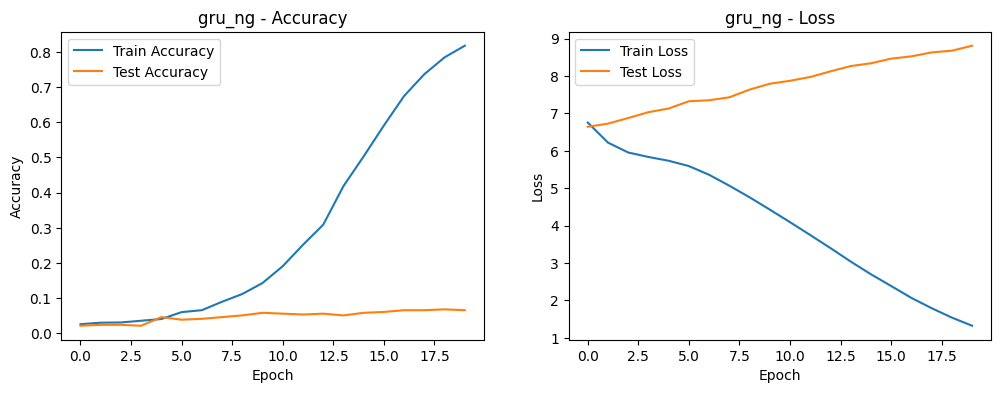

In [118]:
plot_results(gru_ng_hist, "gru_ng")


In [119]:
gru_ng.save(f"models/gru/ng_{percent_sample}.keras")

#### BoW

In [120]:
gru_bow = gru_model("sp", vocab_size)
gru_bow_hist = gru_bow.fit(X_train_bow, y_train_bow, epochs=5, validation_data=(X_test_bow, y_test_bow))

Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.0149 - loss: 6.7526 - val_accuracy: 0.0168 - val_loss: 6.6316
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.0281 - loss: 6.1525 - val_accuracy: 0.0168 - val_loss: 6.7590
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.0284 - loss: 6.1258 - val_accuracy: 0.0168 - val_loss: 7.0668
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.0259 - loss: 6.1324 - val_accuracy: 0.0168 - val_loss: 7.2542
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.0326 - loss: 6.0627 - val_accuracy: 0.0336 - val_loss: 7.2671


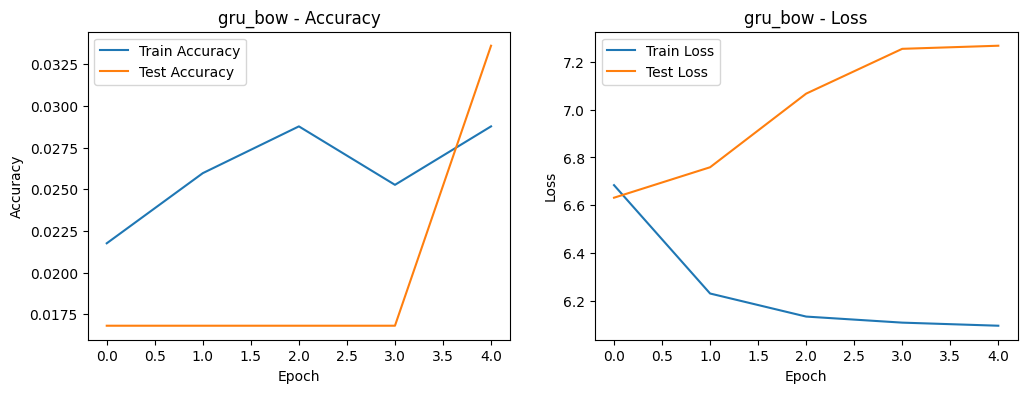

In [121]:
plot_results(gru_bow_hist, "gru_bow")

In [122]:
gru_bow.save(f"models/gru/bow_{percent_sample}.keras")

### LSTM

#### Ngram

In [123]:
lstm_ng = lstm_model("sp", n_gram - 1)
lstm_ng_hist = lstm_ng.fit(X_train_bow, y_train_bow, epochs=5, validation_data=(X_test_bow, y_test_bow))

Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.0117 - loss: 6.7468 - val_accuracy: 0.0280 - val_loss: 6.6078
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.0319 - loss: 6.2879 - val_accuracy: 0.0308 - val_loss: 6.8180
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.0237 - loss: 6.0905 - val_accuracy: 0.0308 - val_loss: 6.9953
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.0295 - loss: 6.0984 - val_accuracy: 0.0168 - val_loss: 7.1360
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.0238 - loss: 6.0590 - val_accuracy: 0.0168 - val_loss: 7.1987


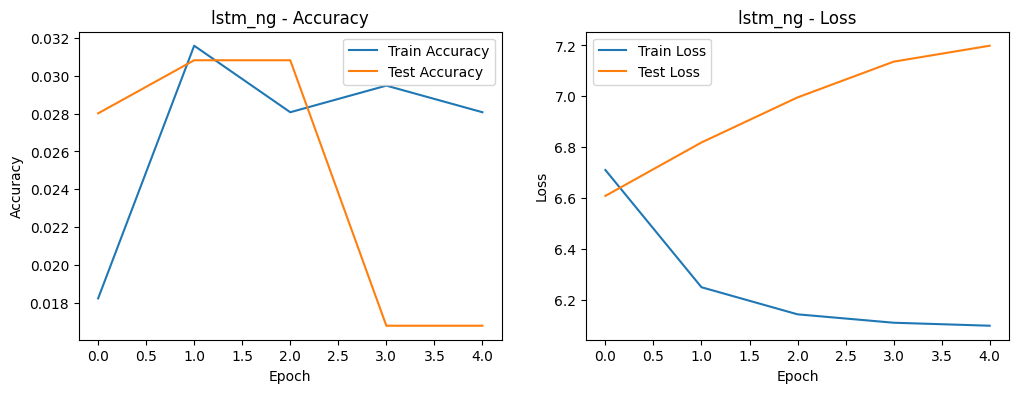

In [124]:
plot_results(lstm_ng_hist, "lstm_ng")

In [125]:
lstm_ng.save(f"models/lstm/ng_{percent_sample}.keras")

#### BoW

In [126]:
lstm_bow = lstm_model("sp", vocab_size)
lstm_bow_hist = lstm_bow.fit(X_train_bow, y_train_bow, epochs=10, validation_data=(X_test_bow, y_test_bow))

Epoch 1/10


c:\PyVenvs\Big_data_venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.0167 - loss: 6.7458 - val_accuracy: 0.0308 - val_loss: 6.6054
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.0245 - loss: 6.2465 - val_accuracy: 0.0308 - val_loss: 6.8258
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.0291 - loss: 6.0580 - val_accuracy: 0.0168 - val_loss: 6.9800
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.0362 - loss: 6.1125 - val_accuracy: 0.0308 - val_loss: 7.2617
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.0260 - loss: 6.0488 - val_accuracy: 0.0168 - val_loss: 7.1953
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.0215 - loss: 6.0727 - val_accuracy: 0.0308 - val_loss: 7.2696
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.0245 - loss: 6.0886 - val_accuracy: 0.0196 - val_loss: 7.2979
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.0300 - loss: 6.0617 - val_accuracy: 0.0196 - val_loss: 7.4334
Epo

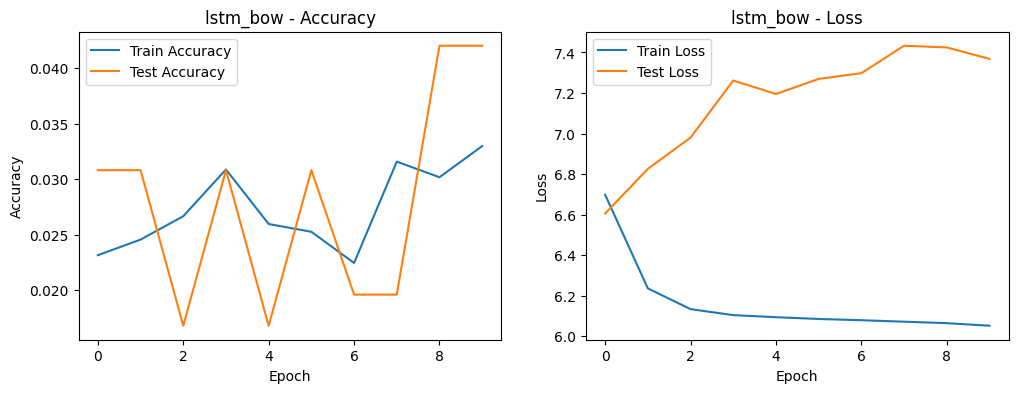

In [127]:
plot_results(lstm_bow_hist, "lstm_bow")

In [128]:
lstm_bow.save(f"models/lstm/bow_{percent_sample}.keras")

## Evaluation

In [129]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test).argmax(axis=1)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
def eval_bow(model, name):
    evaluate_model(model, X_test_bow, y_test_bow, name + "_bow")
    
def eval_ng(model, name):
    evaluate_model(model, X_test_ng, y_test_ng, name + "_ng")

In [130]:
eval_bow(dense_bow, "Dense")
eval_bow(rnn_bow, "RNN")
eval_bow(gru_bow, "GRU")
eval_bow(lstm_bow, "LSTM")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Dense_bow Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         0
          23       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         1
       

In [131]:
eval_ng(dense_ng, "Dense")
eval_ng(rnn_ng, "RNN")
eval_ng(gru_ng, "GRU")
eval_bow(lstm_ng, "LSTM")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Dense_ng Classification Report:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         3
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         3
          21       0.00      0.00      0.00         0
          22       0.00      0.00      0.00         1
          29       0.00      0.00      0.00         1
          30       0.00      0.00      0.00         1
          33       0.00      0.00      0.00         1
          37       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         2
          43       0.00      0.00      0.00         1
          44       0.00      0.00      0.00         1
        

# Word prediction

## Vars definition

In [132]:
want_percent = percent_sample

## Load models

In [133]:
dense_bow = load_model(f"models/dense/bow_{want_percent}.keras")
dense_ng = load_model(f"models/dense/ng_{want_percent}.keras")

gru_bow = load_model(f"models/gru/bow_{want_percent}.keras")
gru_ng = load_model(f"models/gru/ng_{want_percent}.keras")

rnn_bow = load_model(f"models/rnn/bow_{want_percent}.keras")
rnn_ng = load_model(f"models/rnn/ng_{want_percent}.keras")

lstm_bow = load_model(f"models/dense/bow_{want_percent}.keras")
lstm_ng= load_model(f"models/dense/ng_{want_percent}.keras")

## Functions

In [134]:
def generate_text(
    model, 
    seed_text, 
    word_to_idx, 
    idx_to_word, 
    mode="ngram", 
    num_words=5, 
    temperature=1.0, 
    top_k=5
):
    """
    Генерирует последовательность слов на основе начального текста.
    
    Parameters:
        model: обученная модель
        seed_text: начальный текст (строка)
        word_to_idx: словарь слово -> индекс
        idx_to_word: словарь индекс -> слово
        mode: "ngram" (RNN/GRU) или "bow"
        num_words: количество слов для генерации
        temperature: уровень случайности (0.1-2.0)
        top_k: выбор из топ-K вероятных слов
    """
    generated = seed_text.split()
    tokens = word_tokenize(seed_text.lower())
    tokens_idx = [word_to_idx.get(word, word_to_idx.get("<UNK>", 0)) for word in tokens]

    for _ in range(num_words):
        # Подготовка входных данных
        if mode == "bow":
            # window_size = 5
            context = tokens_idx[-window_size:]
            if len(context) < window_size:
                context = [0] * (window_size - len(context)) + context
            
            bow_vector = np.zeros(len(word_to_idx))
            for idx in context:
                bow_vector[idx] += 1
            input_data = bow_vector.reshape(1, -1)
            
        elif mode == "ngram":
            # n_gram = 3
            seq_length = n_gram - 1
            context = tokens_idx[-seq_length:]
            if len(context) < seq_length:
                context = [0] * (seq_length - len(context)) + context
            input_data = np.array([context])
        
        # Предсказание
        preds = model.predict(input_data, verbose=0)[0]
        preds = np.log(preds) / temperature  # Применяем температуру
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        
        # Выбор из топ-K слов
        top_indices = np.argpartition(preds, -top_k)[-top_k:]
        top_probs = preds[top_indices]
        top_probs = top_probs / np.sum(top_probs)  # Нормализуем
        
        # Сэмплирование
        chosen_idx = np.random.choice(top_indices, p=top_probs)
        chosen_word = idx_to_word.get(chosen_idx, "<UNK>")
        
        # Обновляем контекст
        generated.append(chosen_word)
        tokens_idx.append(chosen_idx)

    return " ".join(generated)

In [135]:
def test_gen(
    sentence: str,
    words: int,
    top_k: int,
):
    bow_d = generate_text(
        dense_bow,
        sentence,
        global_word_to_idx,
        global_idx_to_word,
        mode="bow",
        top_k=top_k,
        num_words=words,
    )
    bow_g = generate_text(
        gru_bow,
        sentence,
        global_word_to_idx,
        global_idx_to_word,
        mode="bow",
        top_k=top_k,
        num_words=words,
    )
    bow_r = generate_text(
        rnn_bow,
        sentence,
        global_word_to_idx,
        global_idx_to_word,
        mode="bow",
        top_k=top_k,
        num_words=words,
    )
    bow_l = generate_text(
        lstm_bow,
        sentence,
        global_word_to_idx,
        global_idx_to_word,
        mode="bow",
        top_k=top_k,
        num_words=words,
    )

    ng_d = generate_text(
        dense_ng,
        sentence,
        global_word_to_idx,
        global_idx_to_word,
        mode="ngram",
        top_k=top_k,
        num_words=words,
    )
    ng_g = generate_text(
        gru_ng,
        sentence,
        global_word_to_idx,
        global_idx_to_word,
        mode="ngram",
        top_k=top_k,
        num_words=words,
    )
    ng_r = generate_text(
        rnn_ng,
        sentence,
        global_word_to_idx,
        global_idx_to_word,
        mode="ngram",
        top_k=top_k,
        num_words=words,
    )
    ng_l = generate_text(
        lstm_ng,
        sentence,
        global_word_to_idx,
        global_idx_to_word,
        mode="ngram",
        top_k=top_k,
        num_words=words,
    )

    print("BOW:")
    print("dense:\t" + bow_d)
    print("gru:\t" + bow_g)
    print("rnn:\t" + bow_r)
    print("ltsm:\t" + bow_l)

    print()

    print("NGRAM:")
    print("dense:\t" + ng_d)
    print("gru:\t" + ng_g)
    print("rnn:\t" + ng_r)
    print("ltsm:\t" + ng_l)

## Tests

In [142]:
input_sentence = "I love this model for"

test_gen(input_sentence, 5, 3)

C:\Users\artem\AppData\Local\Temp\ipykernel_16496\3261994695.py:51: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature  # Применяем температуру


BOW:
dense:	I love this model for laptop good laptop laptop quality
gru:	I love this model for 5 good battery good laptop
rnn:	I love this model for 5 5 5 4 5
ltsm:	I love this model for good best laptop laptop laptop

NGRAM:
dense:	I love this model for performance display highly display 4
gru:	I love this model for u purchase office professional heavy
rnn:	I love this model for ram wants controls sufficient features
ltsm:	I love this model for performance keyboard laptop good till
